               t        co2
count   23.00000  23.000000
mean    66.00000   0.167411
std     40.69398   0.096106
min      0.00000   0.005357
25%     33.00000   0.066964
50%     66.00000   0.198214
75%     99.00000   0.251786
max    132.00000   0.294643
R^2:  86.01 %
Fitted Parameters are : [5.58517848e+00 5.54989724e-03]


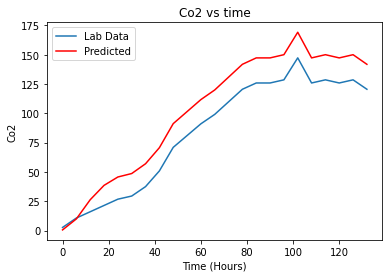

In [11]:
####### co2 vs t
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import C

path=r"/Users/shaktimukker/Documents/MyProjects/projects/bacterial-growth-analysis/"
data_co2_vs_t=pd.read_excel(path+"data.xlsx",sheet_name="co2_vs_t")
print(data_co2_vs_t.describe())

# CO2 vs t
def co2_vs_t(X,Yxco2,Mco2):
    Xm,Um=184,.33
    t=X
    comn=1+((Xm/C.X0)-1)*np.exp(-Um*t)
    RHS1=1/(Yxco2*comn)
    RHS2=1/(Yxco2*(Xm/C.X0))
    RHS3=(Mco2/Um)*np.log(comn/((Xm/C.X0)*np.exp(-Um*t)))
    return C.CCP0+Xm*(RHS1-RHS2+RHS3)

g=[2.60,.005]
t=data_co2_vs_t["t"].values
X=data_co2_vs_t["co2"].values
X=500*X
g,cov=curve_fit(co2_vs_t,t,X,g)
y =[co2_vs_t(t,g[0],g[1]) for t in X]

plt.plot(t,X,label='Lab Data')
plt.plot(t,y,'r',label='Predicted')
plt.xlabel("Time (Hours)")
plt.ylabel("Co2")
plt.title("Co2 vs time")
plt.legend()

print('R^2: ', round(100*r2_score(y,X),2),"%")
#print('R^2: ', r2_score(X,y))
print("Fitted Parameters are :",g)

                t          x
count   21.000000  21.000000
mean    88.000000  17.942177
std     49.638695   3.982831
min      8.000000  10.000000
25%     48.000000  15.535714
50%     88.000000  18.571429
75%    128.000000  21.071429
max    168.000000  23.928571
R^2:  17.0 %
Fitted parameters are : [18.70321484  0.19860917]


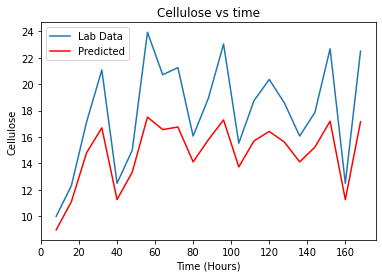

In [21]:
# x vs t
path=r"/Users/shaktimukker/Documents/MyProjects/projects/bacterial-growth-analysis/"
data_x_vs_t=pd.read_excel(path+"data.xlsx",sheet_name="x_vs_t")
print(data_x_vs_t.describe())

# X vs t
def x_vs_t(X,Xm,Um):
    t=X
    return Xm/(1+((Xm/C.X0)-1)*np.exp(-Um*t))

g=[184,.33]
t=data_x_vs_t["t"].values
X=data_x_vs_t["x"].values
g,cov=curve_fit(x_vs_t,t,X,g)
y =[x_vs_t(t,g[0],g[1]) for t in X]

plt.plot(t,X,label="Lab Data")
plt.plot(t,y,'r',label="Predicted")
plt.ylabel("Cellulose")
plt.xlabel("Time (Hours)")
plt.title("Cellulose vs time")
plt.legend()

print('R^2: ', 100*round(r2_score(X,y),2),"%")

print("Fitted parameters are :",g)
